# WGCNA
weighted gene co-expression network analysis

# Phase 2 vs. Phase 2

following [Hovrath Lab Tutorial](https://www.dropbox.com/scl/fo/4vqfiysan6rlurfo2pbnk/h?dl=0&e=1&preview=Consensus-NetworkConstruction-man.pdf&rlkey=thqg8wlpdn4spu3ihjuc1kmlu)

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)

In [3]:
# important setting, cannot omit
options(stringsAsFactors = FALSE)

In [4]:
# allow multi-threading within WGCNA
enableWGCNAThreads()

Allowing parallel execution with up to 23 working processes.


## 1. structure WGCNA input

**Expected input**:
- Rows = samples
- Columns = genes (or probes/features)
- Values = numeric expression values

### A. format vst normalized counts matrix

In [13]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 94 samples x 35466 genes

,LOC111116054,LOC111126949,LOC111110729,LOC111112434,LOC111120752,LOC111128944,LOC111128953,LOC111105691,LOC111133554,LOC111125466,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
B1_B1_O01,7.692872,10.197580,8.354765,7.886383,9.363550,7.548551,7.548551,7.692872,7.548551,7.650623,⋯,18.94773,17.35567,16.72734,16.55278,17.40296,17.50511,15.27334,14.40950,17.08613,13.21049
B1_W5_O50,7.805746,9.653169,8.542687,7.697174,9.355360,7.548551,7.548551,7.845404,7.548551,7.548551,⋯,19.25087,17.60046,17.05547,16.54477,16.97662,17.30129,15.59674,14.95796,17.21506,13.41728
B2_B5_O51,7.871959,9.900281,8.351593,7.548551,9.509373,7.548551,7.548551,8.595408,7.548551,7.651014,⋯,19.41971,17.94342,17.27196,17.23549,17.79404,18.11808,15.98559,15.64247,17.74181,13.77409
B2_C4_O40,7.843091,9.718856,8.513945,7.687586,9.284512,7.548551,7.548551,8.101515,7.843091,7.548551,⋯,18.86611,17.79882,17.27281,16.61824,17.19524,17.19285,15.14694,14.83363,17.01083,13.11047
B3_B4_O41,7.548551,9.612738,8.518601,7.940109,9.198871,7.548551,7.548551,8.014009,7.548551,7.661902,⋯,19.71514,18.17021,17.54836,17.11674,17.49138,17.97654,15.71235,15.28878,17.71717,13.87237
B3_C3_O30,7.909124,9.545333,8.653091,7.989592,9.337765,7.548551,7.710140,8.149132,7.828140,7.926626,⋯,19.27273,17.87689,17.64807,17.08072,17.29751,17.13546,15.58747,15.14063,17.14174,13.28853


[1]    94 35466

### B. identify and remove genes with missing data 
genes with too many NAs or zero-counts

In [14]:
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
gsg$allOK

dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
dim(dataExpr) # 94 samples x 35396 genes

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 70 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

[1]    94 35396

### C. Sample size and gene filtering

removing low-variance genes first:

In [15]:
dataExpr <- dataExpr[, apply(dataExpr, 2, var) > quantile(apply(dataExpr, 2, var), 0.25)]
dim(dataExpr) # 94 samples x 26547 genes

[1]    94 26547

### D. Sample outlier detection

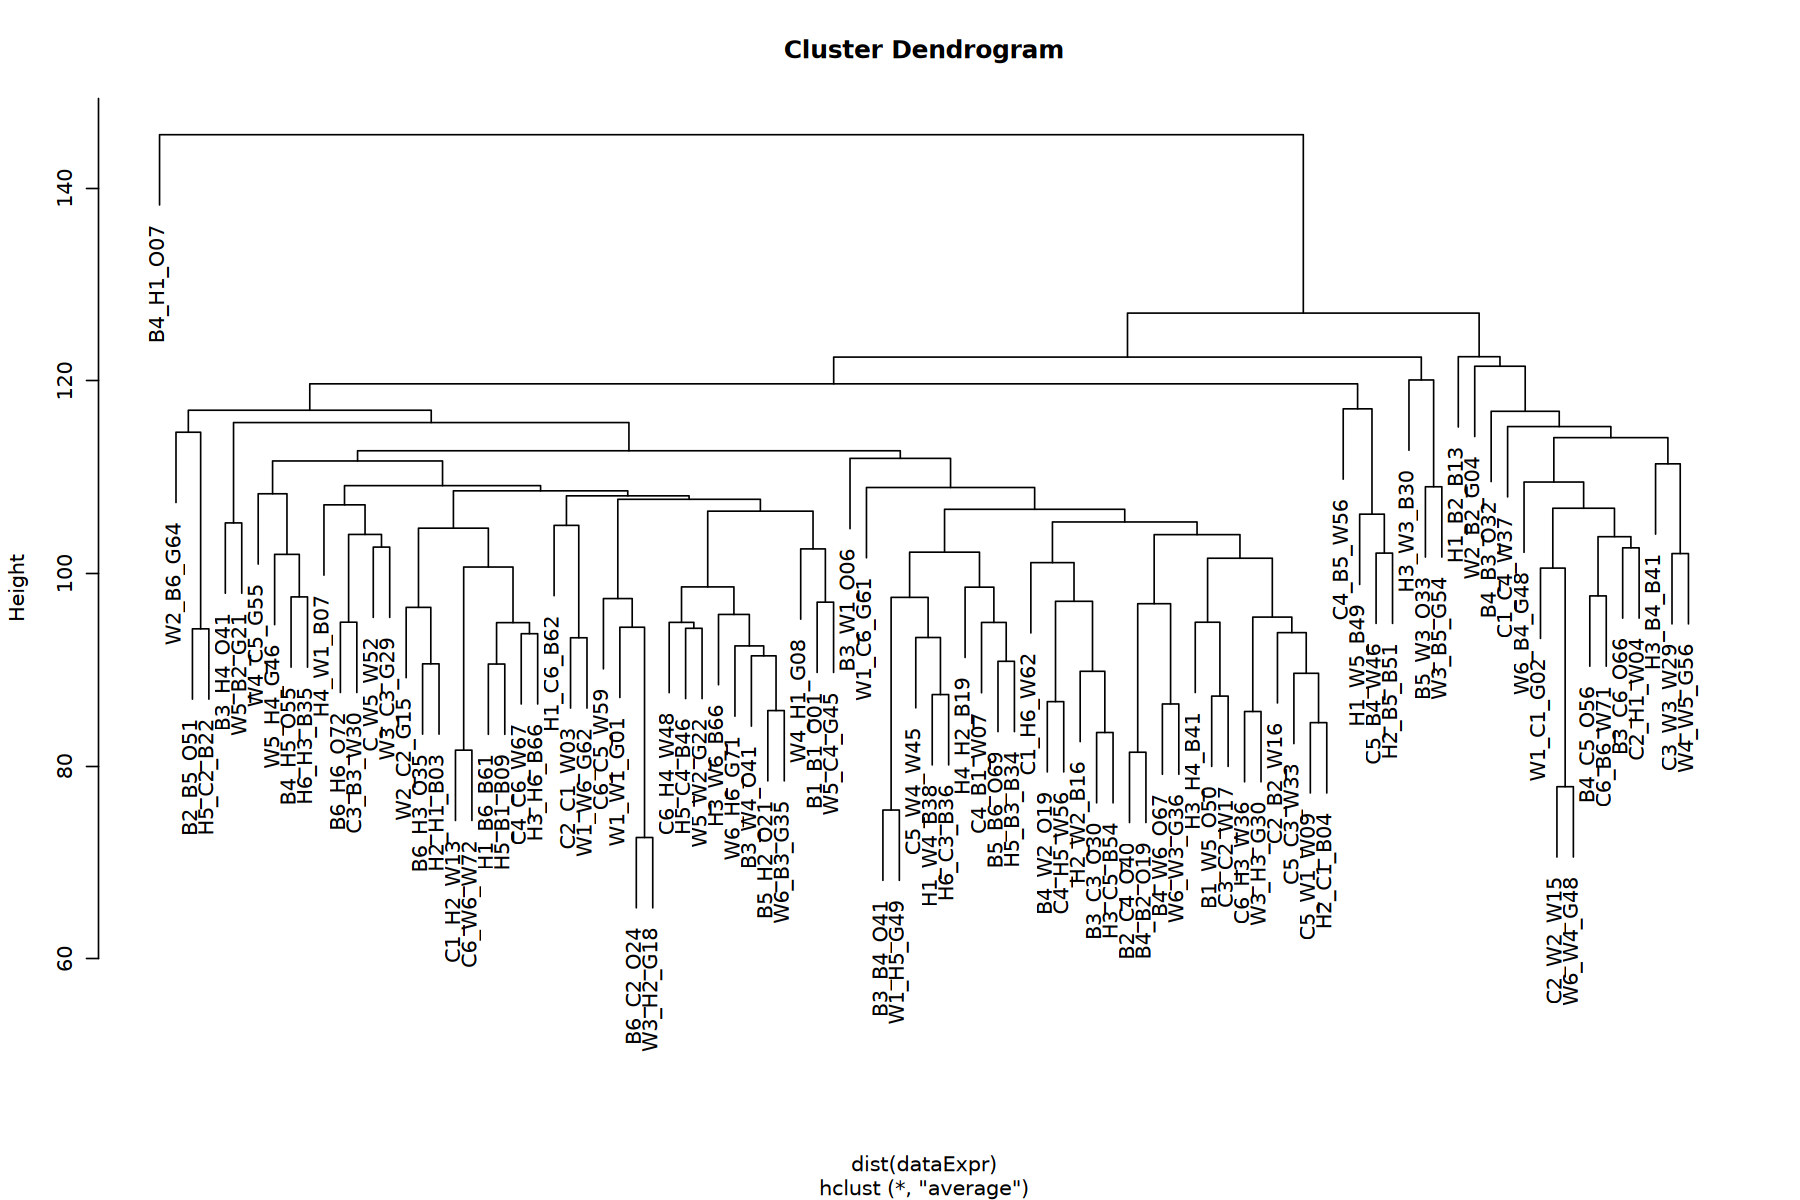

In [16]:
options(repr.plot.width = 15, repr.plot.height = 10)

sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

only obvious outlier - B4_H1_O07 - becuase it clusters above the rest of the tree and is separated from the main cluster - going to remove it from analysis

In [20]:
dataExpr <- dataExpr[!rownames(dataExpr) %in% c("B4_H1_O07"), ]
dim(dataExpr) # 93 samples x 26547 genes

[1]    93 26547

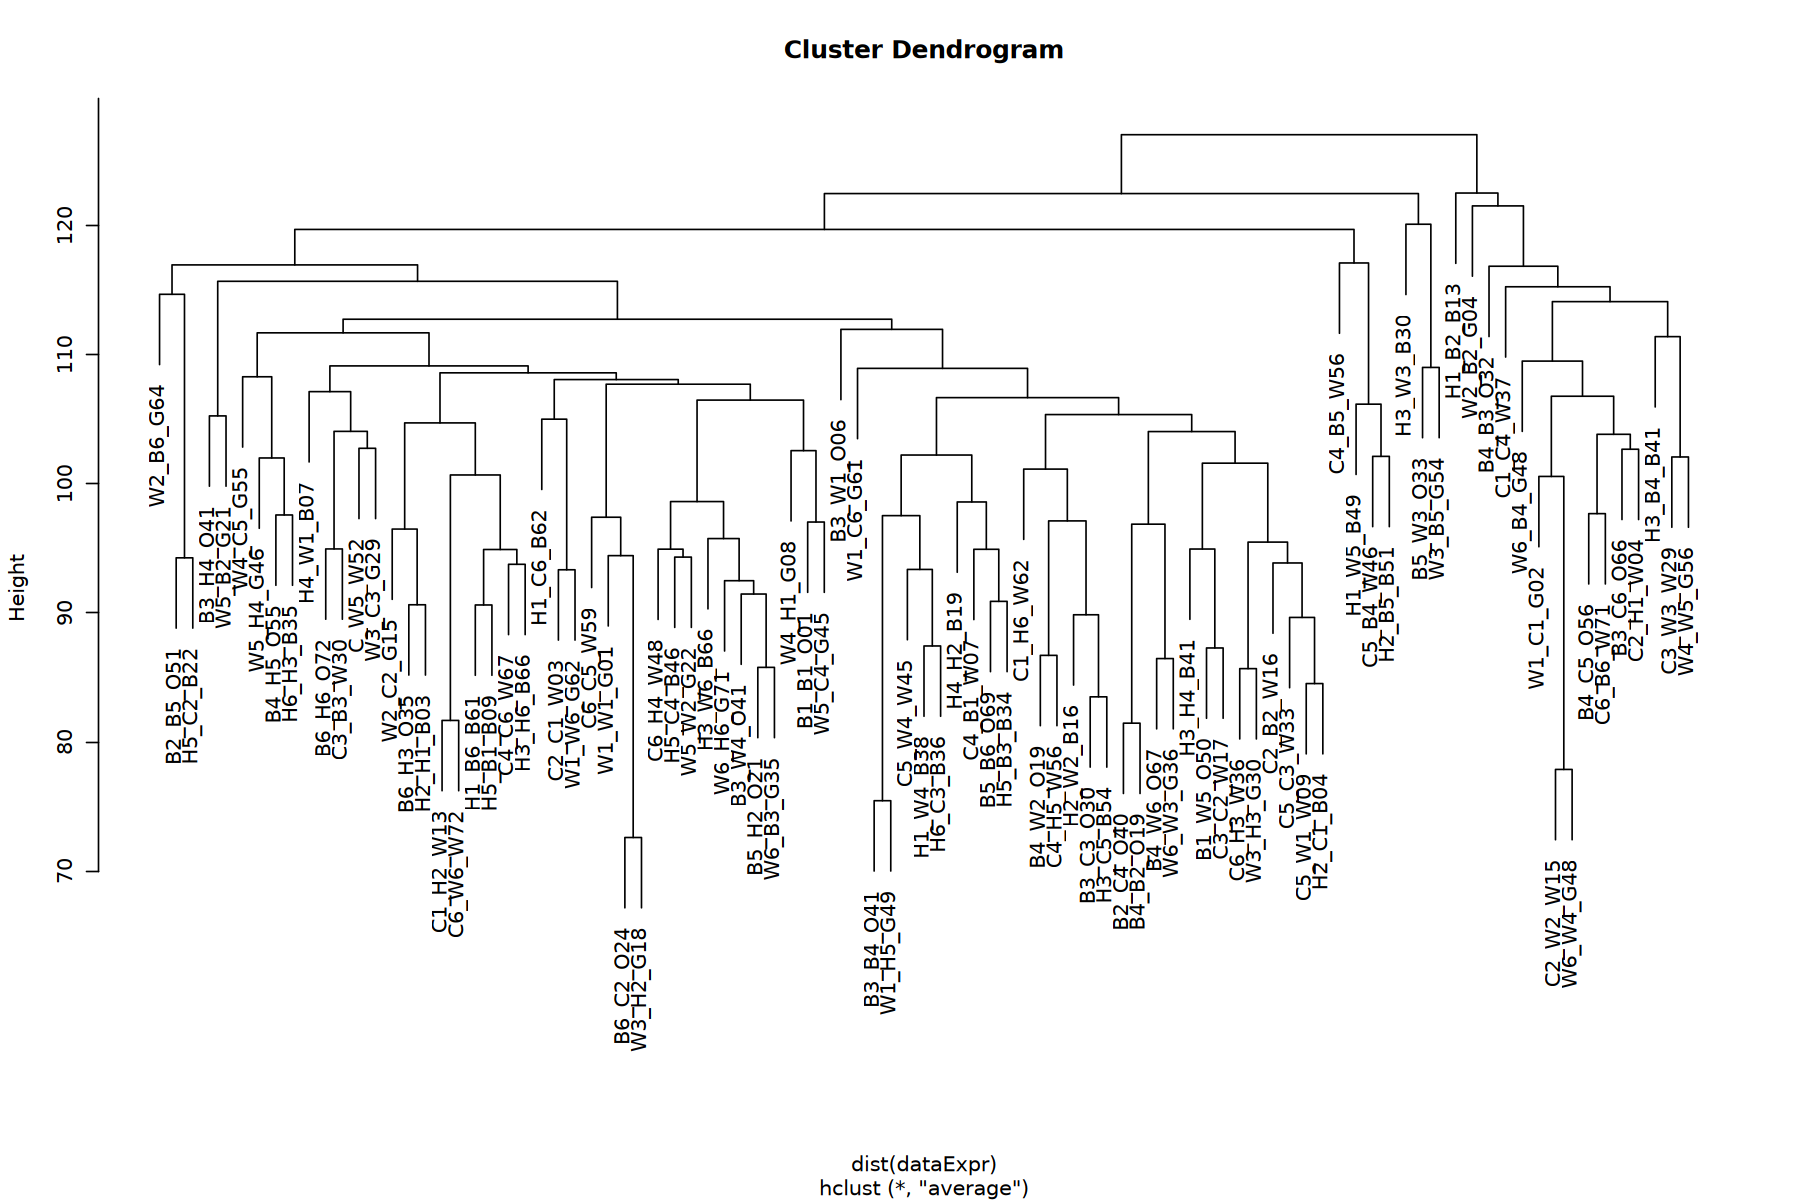

In [21]:
# replot without outliers
sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

looks much better!

### meta data
could add phenotypic data to this ...

In [22]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

# removing same samples as dataExpr
meta <- meta[rownames(meta) %in% rownames(dataExpr), ]

head(meta)
dim(meta) # 92 samples

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4
B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3


[1] 93  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [23]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

In [24]:
# double checking the samples in rownames are the same
all(rownames(meta) == rownames(dataExpr))

[1] TRUE

## 2. simple WGCNA network construction and module identification
start with simple, can progress to consensus if deemed necessary

In [25]:
# final QC check
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK) {
  dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
}

gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### A. choose soft thresholding power (β)
analysis of network topology

In [26]:
powers <- c(1:20)
sft <- pickSoftThreshold(
  dataExpr,
  powerVector = powers,
  networkType = "signed",
  verbose = 5
)


pickSoftThreshold: will use block size 1685.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1685 of 26547
   ..working on genes 1686 through 3370 of 26547
   ..working on genes 3371 through 5055 of 26547
   ..working on genes 5056 through 6740 of 26547
   ..working on genes 6741 through 8425 of 26547
   ..working on genes 8426 through 10110 of 26547
   ..working on genes 10111 through 11795 of 26547
   ..working on genes 11796 through 13480 of 26547
   ..working on genes 13481 through 15165 of 26547
   ..working on genes 15166 through 16850 of 26547
   ..working on genes 16851 through 18535 of 26547
   ..working on genes 18536 through 20220 of 26547
   ..working on genes 20221 through 21905 of 26547
   ..working on genes 21906 through 23590 of 26547
   ..working on genes 23591 through 25275 of 26547
   ..working on genes 25276 through 26547 of 26547
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.0177 -12.

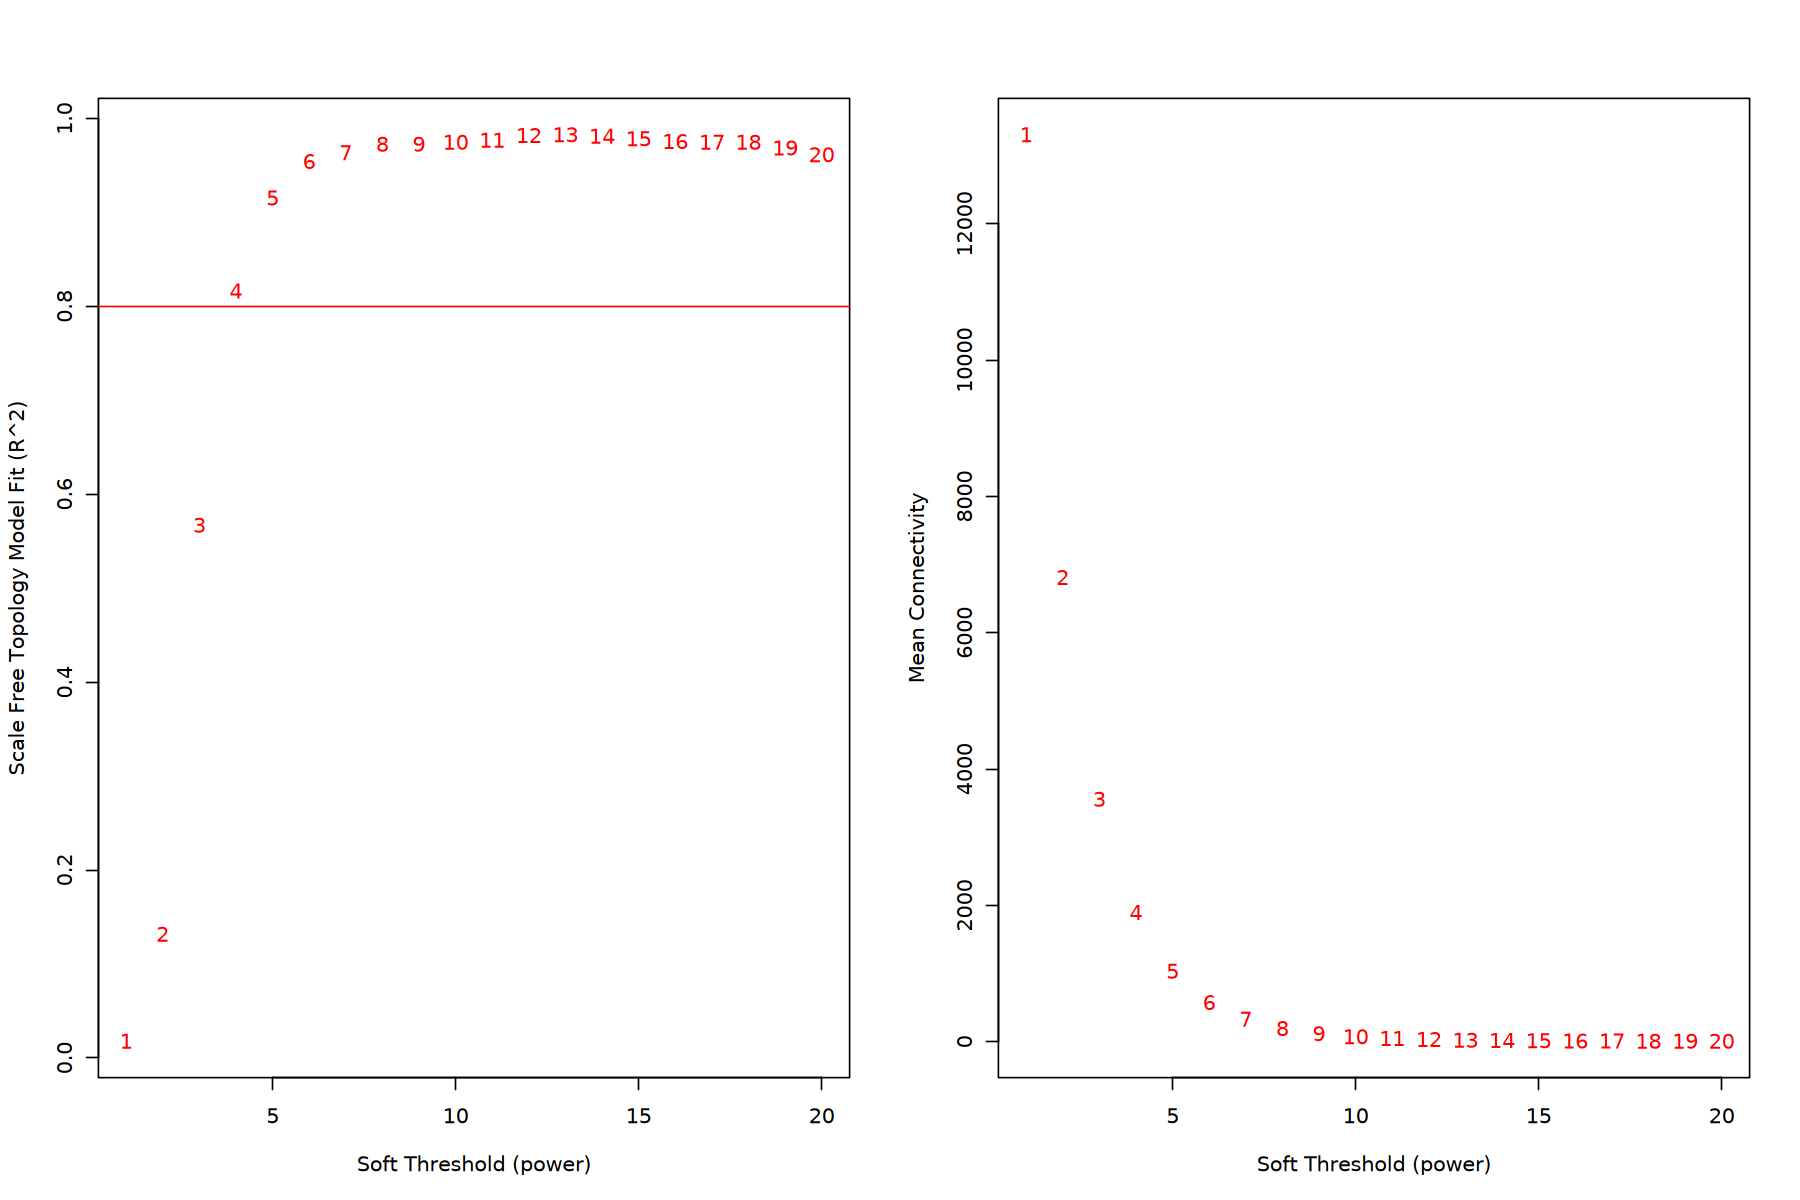

In [27]:
par(mfrow = c(1,2))
plot(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  xlab = "Soft Threshold (power)",
  ylab = "Scale Free Topology Model Fit (R^2)",
  type = "n"
)
text(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  labels = powers,
  col = "red"
)
abline(h = 0.8, col = "red")

plot(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  xlab = "Soft Threshold (power)",
  ylab = "Mean Connectivity",
  type = "n"
)
text(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  labels = powers,
  col = "red"
)


#### left plot - scale-free topology
the red line is where R^2 is 0.8 - you want the lowest power that reaches this - 4 is just above 0.8 and anything after 6 plateaus

#### right plot - mean connectivity
connectivity should not collapse to 0 - by power 8-10, the connectivity approaches 0

based on this, I think power of 5 should be appropriate

### B. co-expression similarity and adjacency

In [28]:
softPower <- 5

calculate co-expression adjacency using soft threshold power of 5

In [29]:
adjacency <- adjacency(dataExpr, power = softPower)
head(adjacency)

,LOC111126949,LOC111120752,LOC111105691,LOC111113860,LOC111109550,LOC111109753,LOC111109452,LOC111124802,LOC111101273,LOC111101250,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
LOC111126949,1.000000e+00,1.782543e-03,2.752219e-08,4.600205e-07,9.155717e-05,1.656267e-05,8.391595e-13,2.581975e-03,1.319233e-02,4.230721e-05,⋯,7.160573e-07,1.558930e-05,5.919973e-06,1.493077e-04,2.374682e-09,5.391527e-09,5.879192e-05,1.105667e-08,2.965007e-06,6.959330e-07
LOC111120752,1.782543e-03,1.000000e+00,1.716104e-06,3.146263e-08,7.358584e-05,1.762023e-09,1.690230e-05,1.070843e-05,3.894397e-02,1.183032e-05,⋯,8.026964e-03,6.595698e-03,1.598050e-02,4.779981e-03,3.795156e-02,4.617818e-03,2.676368e-02,1.774048e-02,1.566690e-02,1.381881e-02
LOC111105691,2.752219e-08,1.716104e-06,1.000000e+00,1.084102e-06,1.915999e-05,2.407908e-07,6.601852e-07,6.362332e-11,5.738142e-08,2.303477e-04,⋯,2.204940e-04,1.582523e-08,5.902503e-10,4.193395e-08,1.465177e-06,4.447607e-05,2.631513e-11,1.409498e-07,1.039271e-05,2.704959e-09
LOC111113860,4.600205e-07,3.146263e-08,1.084102e-06,1.000000e+00,2.333026e-05,8.882854e-06,3.091483e-04,1.303715e-07,1.645528e-07,5.683632e-07,⋯,6.034621e-06,4.048877e-04,1.244493e-03,1.803356e-04,7.549985e-06,2.280600e-06,6.601983e-04,4.168502e-05,2.332036e-04,4.252386e-04
LOC111109550,9.155717e-05,7.358584e-05,1.915999e-05,2.333026e-05,1.000000e+00,4.656518e-06,4.186890e-08,2.371397e-05,2.300438e-07,1.194374e-06,⋯,6.849831e-15,2.213905e-04,7.697647e-08,7.936029e-06,4.187663e-07,8.517485e-10,7.454661e-10,5.411355e-08,1.497762e-07,1.762907e-14
LOC111109753,1.656267e-05,1.762023e-09,2.407908e-07,8.882854e-06,4.656518e-06,1.000000e+00,2.298499e-08,2.020960e-04,8.740811e-04,2.179421e-08,⋯,3.920238e-05,1.177167e-06,4.570454e-16,3.930212e-07,8.284044e-07,1.910615e-04,1.535774e-07,4.270411e-05,1.626405e-04,1.795192e-05


### C. Topological Overlap Matrix (TOM)
transform adjacency into TOM to minimize effects of noise and spurious associations - calculate corresponding dissimilarity

In [30]:
# turn adjacency into topological overlap
TOM <- TOMsimilarity(adjacency)
head(TOM)

# calculate dissimilarity
dissTOM <- 1-TOM
head(dissTOM)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


1.0000000000,0.0042933083,1.852709e-04,5.818304e-04,0.0005404566,0.0003144408,0.0005682741,0.0020470717,0.0071768146,0.0037048014,⋯,0.0004408250,0.0005759230,0.0005677051,0.0004982259,0.0008827370,0.0003837645,0.0007463244,0.0005814072,0.0006610943,0.0004647112
0.0042933083,1.0000000000,2.773913e-04,1.873669e-03,0.0004478330,0.0001914498,0.0012254369,0.0010705347,0.0226939637,0.0030848120,⋯,0.0164825038,0.0195005626,0.0236828804,0.0198913808,0.0231048502,0.0120065692,0.0230095491,0.0235759301,0.0164464391,0.0184666636
0.0001852709,0.0002773913,1.000000e+00,5.565506e-05,0.0001184485,0.0002327076,0.0001395993,0.0001562924,0.0001999636,0.0007183777,⋯,0.0003600078,0.0001663546,0.0001553802,0.0001165873,0.0002603584,0.0002545397,0.0002055112,0.0002058637,0.0003232873,0.0001910332
0.0005818304,0.0018736690,5.565506e-05,1.000000e+00,0.0001005873,0.0001449656,0.0014757616,0.0003609820,0.0011261494,0.0016916643,⋯,0.0005621569,0.0006108221,0.0007841932,0.0004435304,0.0007163779,0.0004381356,0.0010218126,0.0006395913,0.0008489379,0.0006412816
0.0005404566,0.0004478330,1.184485e-04,1.005873e-04,1.0000000000,0.0003099846,0.0001955092,0.0004039726,0.0003043675,0.0003599073,⋯,0.0002965254,0.0003927036,0.0002604835,0.0001557174,0.0003543204,0.0002128943,0.0003100519,0.0003067601,0.0003578739,0.0002432699
0.0003144408,0.0001914498,2.327076e-04,1.449656e-04,0.0003099846,1.0000000000,0.0001828311,0.0004006687,0.0004618206,0.0001673186,⋯,0.0008082062,0.0004760549,0.0001727626,0.0003480783,0.0003218440,0.0011239916,0.0002740738,0.0007224079,0.0027691623,0.0018399482


0.0000000,0.9957067,0.9998147,0.9994182,0.9994595,0.9996856,0.9994317,0.9979529,0.9928232,0.9962952,⋯,0.9995592,0.9994241,0.9994323,0.9995018,0.9991173,0.9996162,0.9992537,0.9994186,0.9993389,0.9995353
0.9957067,0.0000000,0.9997226,0.9981263,0.9995522,0.9998086,0.9987746,0.9989295,0.9773060,0.9969152,⋯,0.9835175,0.9804994,0.9763171,0.9801086,0.9768951,0.9879934,0.9769905,0.9764241,0.9835536,0.9815333
0.9998147,0.9997226,0.0000000,0.9999443,0.9998816,0.9997673,0.9998604,0.9998437,0.9998000,0.9992816,⋯,0.9996400,0.9998336,0.9998446,0.9998834,0.9997396,0.9997455,0.9997945,0.9997941,0.9996767,0.9998090
0.9994182,0.9981263,0.9999443,0.0000000,0.9998994,0.9998550,0.9985242,0.9996390,0.9988739,0.9983083,⋯,0.9994378,0.9993892,0.9992158,0.9995565,0.9992836,0.9995619,0.9989782,0.9993604,0.9991511,0.9993587
0.9994595,0.9995522,0.9998816,0.9998994,0.0000000,0.9996900,0.9998045,0.9995960,0.9996956,0.9996401,⋯,0.9997035,0.9996073,0.9997395,0.9998443,0.9996457,0.9997871,0.9996899,0.9996932,0.9996421,0.9997567
0.9996856,0.9998086,0.9997673,0.9998550,0.9996900,0.0000000,0.9998172,0.9995993,0.9995382,0.9998327,⋯,0.9991918,0.9995239,0.9998272,0.9996519,0.9996782,0.9988760,0.9997259,0.9992776,0.9972308,0.9981601


### D. clustering using TOM
hierarchical clustering tree (dendrogram) of genes

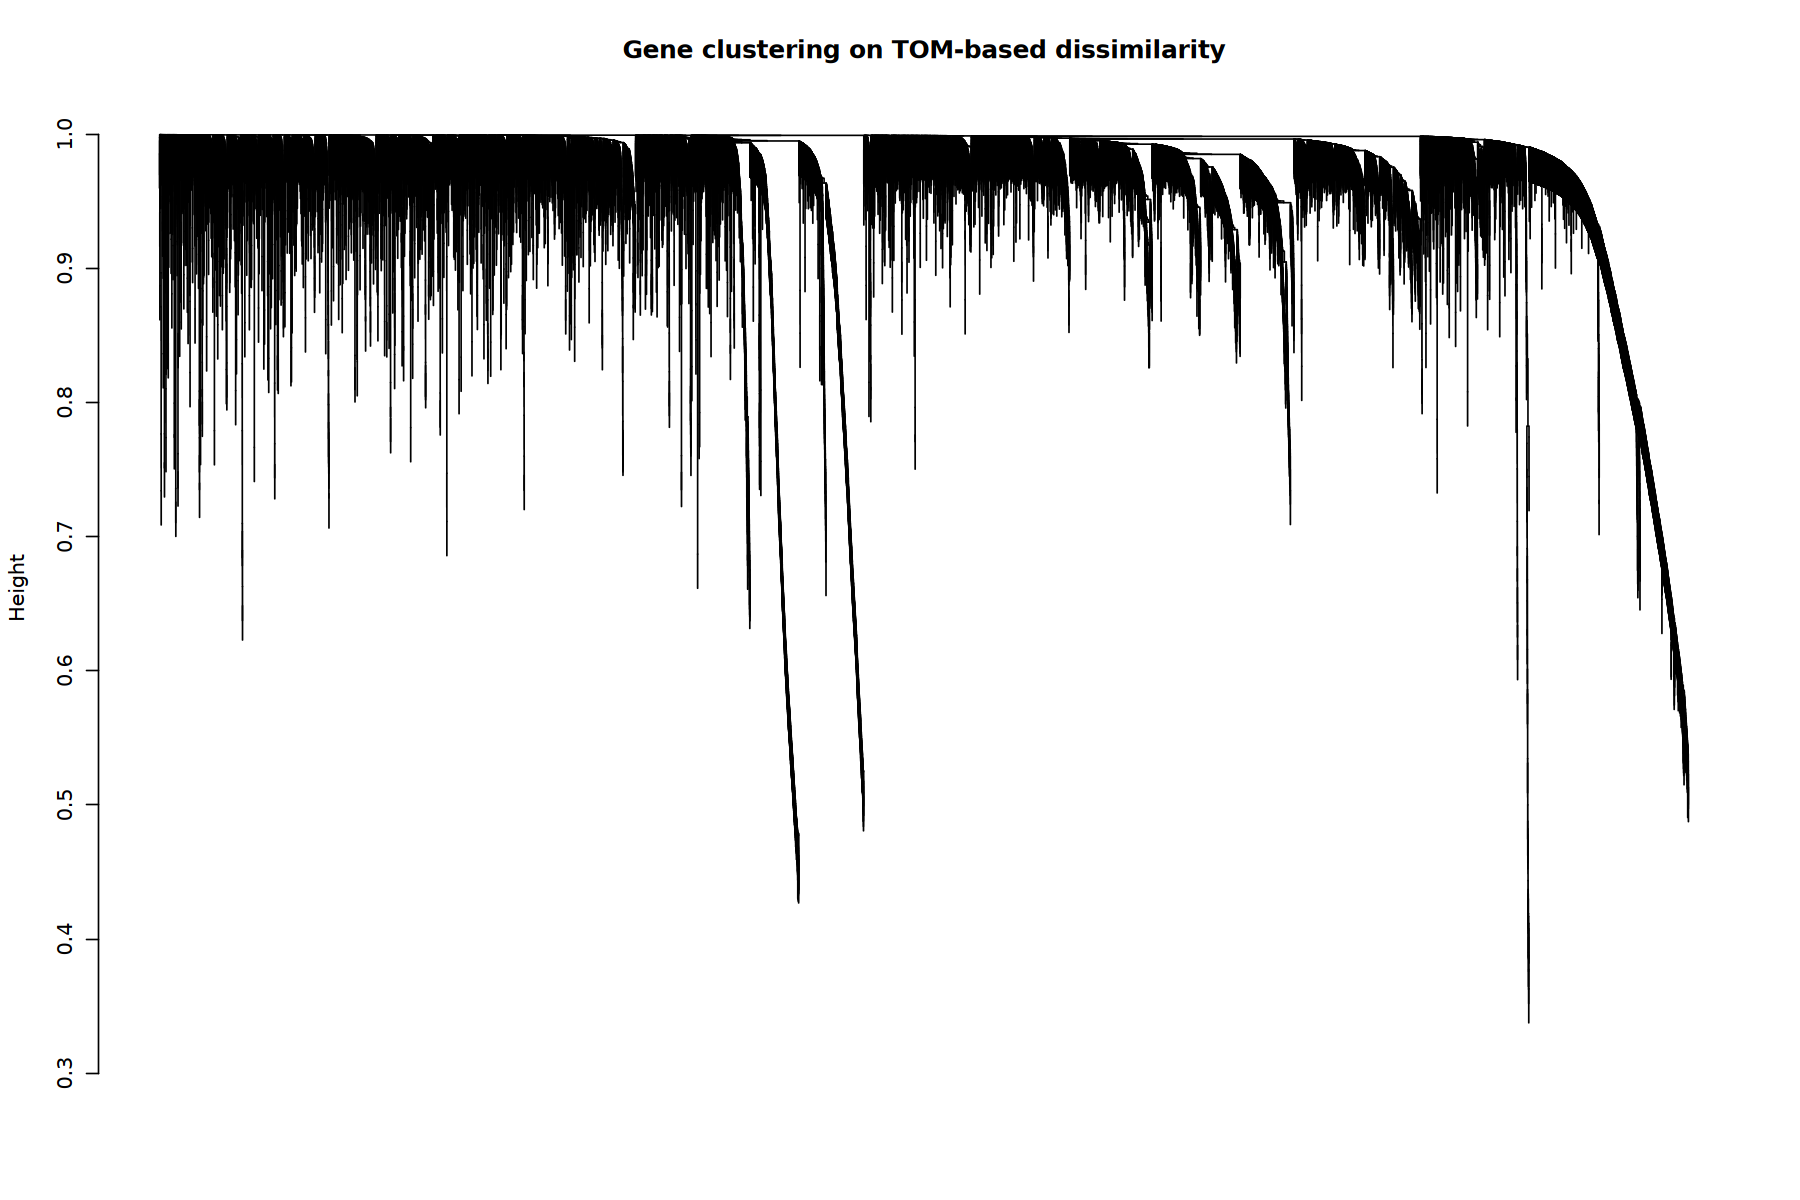

In [31]:
# call hierarchical clustering function
geneTree = hclust(as.dist(dissTOM), method = "average")

# plot the dendrogram
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)

each leaf (short vertical line) corresponds to a gene - branches group together densely interconnected, highly co-expressed genes

module identification = cutting branches off the dendrogram

### E. module identification

set minimum module size - this is the smallest number of genes allowed to be put into a module 

then use Dynamic Tree Cut which is the default method for branch cutting and module detection

In [33]:
# would like large modules, so we set the minimum module size relatively high:
minModuleSize <- 30

# Module identification using dynamic tree cut:
dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM, 
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)
table(dynamicMods)

 ..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3478 4059 3511 2225 1894 1728 1601 1487 1331 1230 1153  602  504  388  315  312 
  16   17   18   19   20   21 
 179  160  148   84   82   76 

21 modules labeled 1-21 returned, largest to smallest - label 0 is for unassigned genes

plot module assignmend under the gene dendrogram:

dynamicColors
       black         blue        brown         cyan      darkred        green 
        1487         3511         2225          315           76         1728 
 greenyellow         grey       grey60    lightcyan   lightgreen  lightyellow 
         602         3478          160          179          148           84 
     magenta midnightblue         pink       purple          red    royalblue 
        1230          312         1331         1153         1601           82 
      salmon          tan    turquoise       yellow 
         388          504         4059         1894 

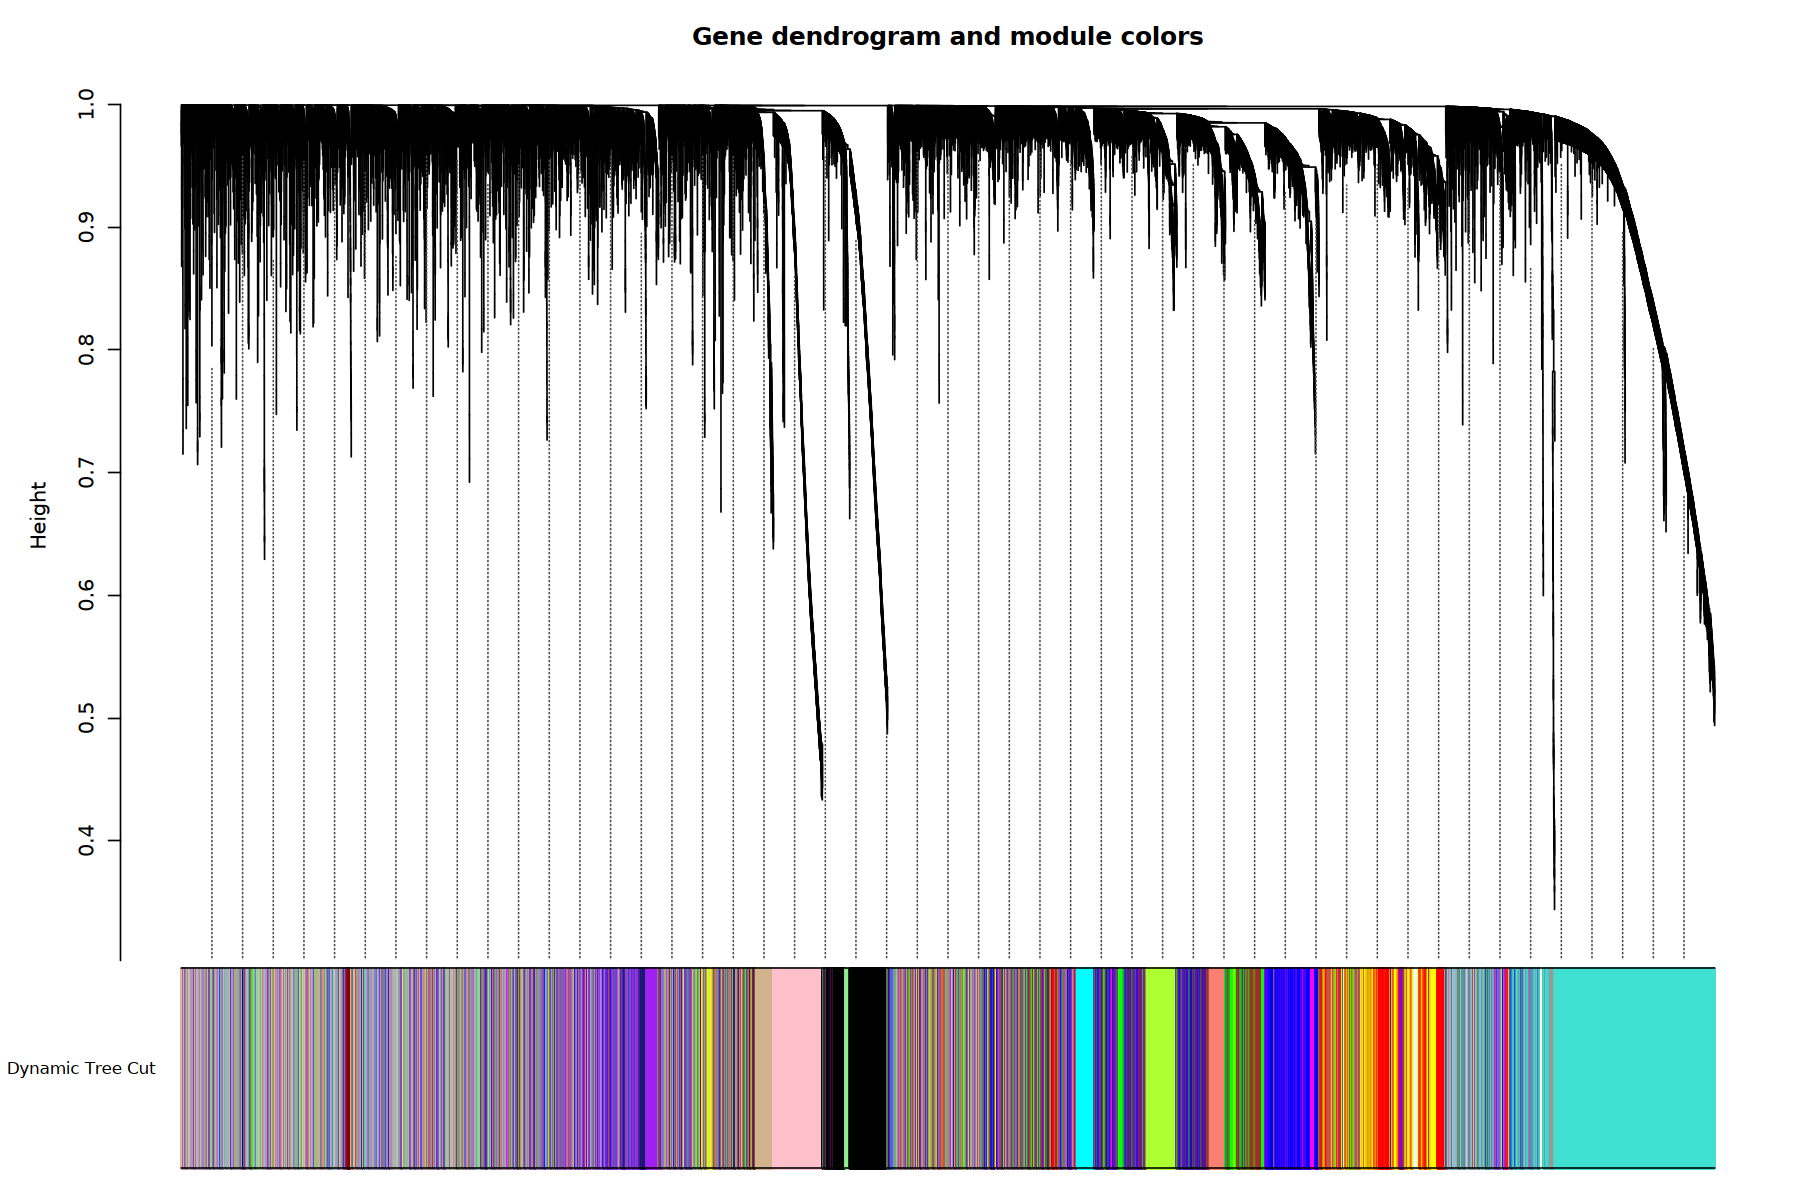

In [34]:
# Convert numeric lables into colors
dynamicColors <- labels2colors(dynamicMods)
table(dynamicColors)

# Plot the dendrogram and colors underneath
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")

### F. merging modules whose GE profiles are similar

this is based on eigengenes, which is the first principal component of a given a gene expression matrix/module that acts as a representative summary profile for a gene module or cluster

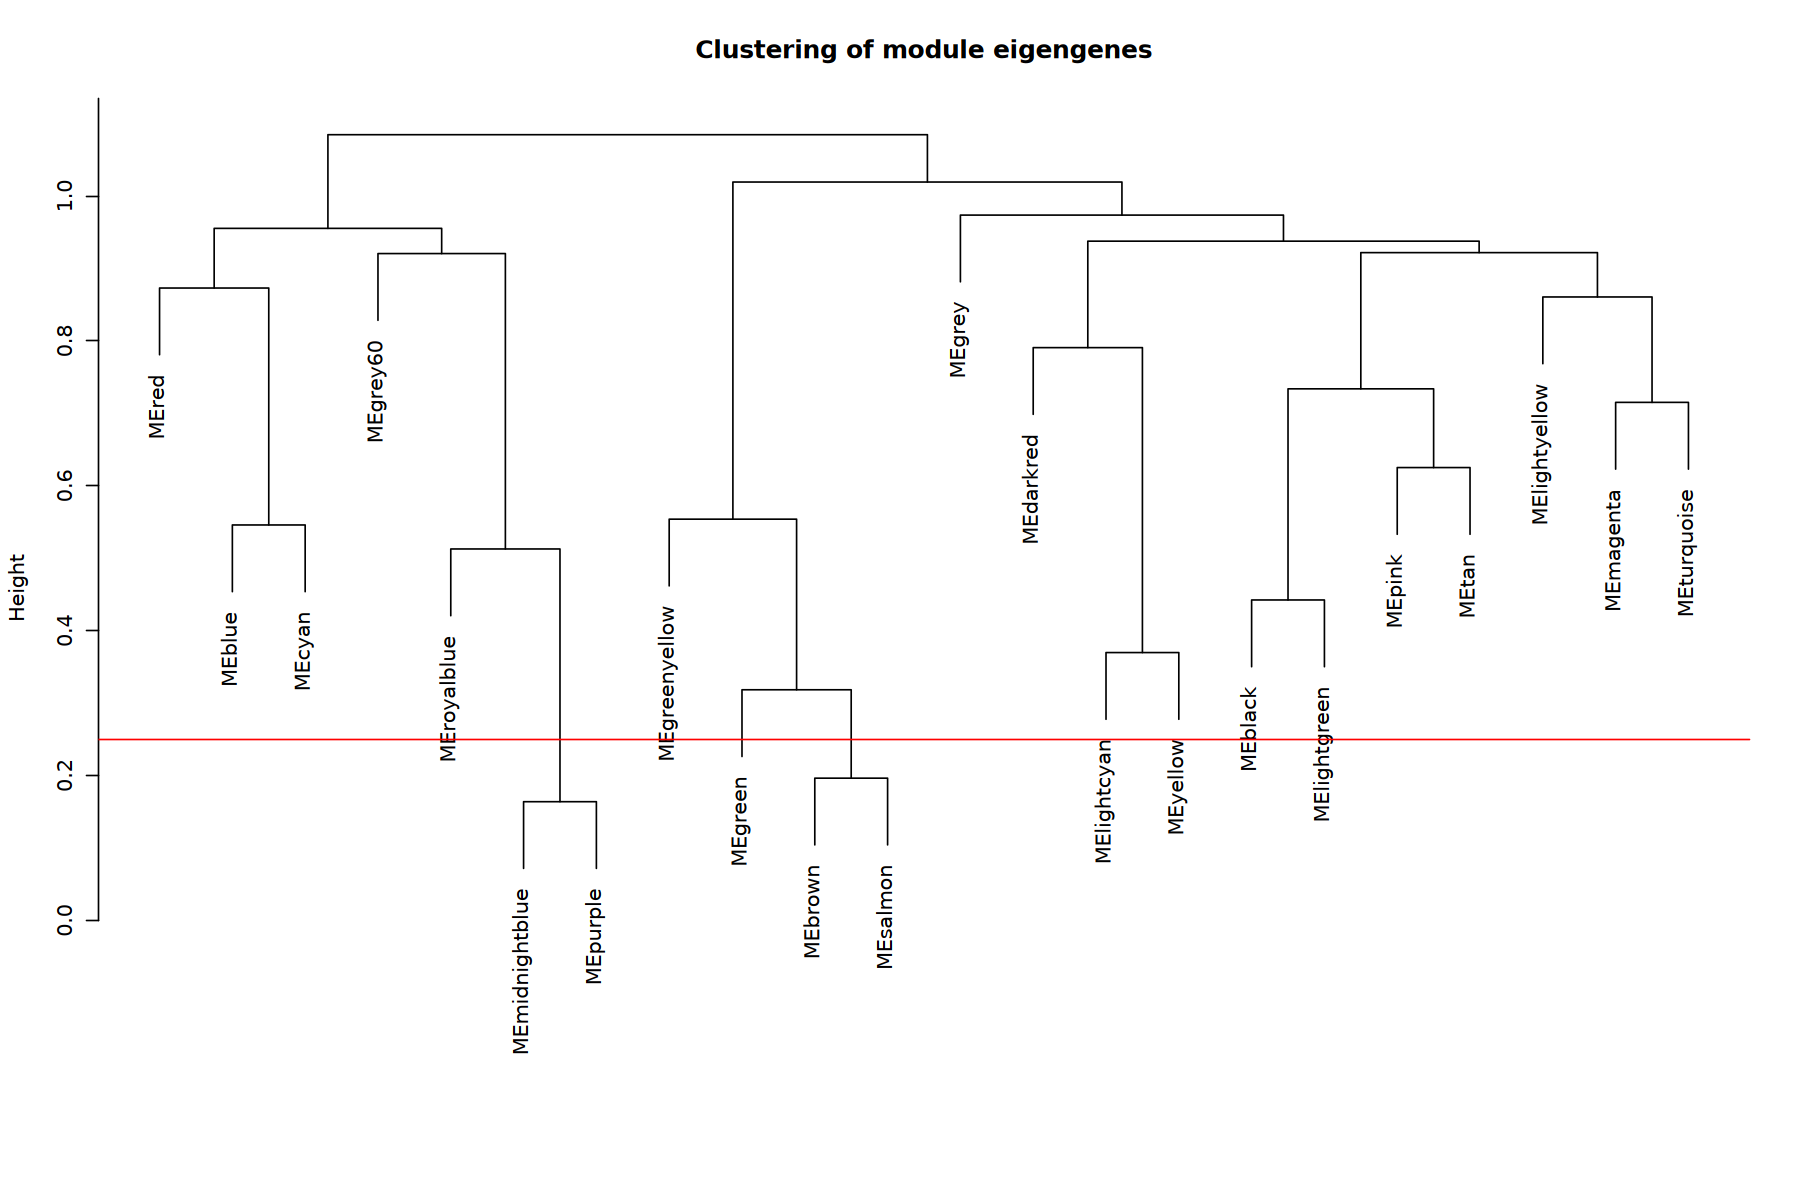

In [44]:
# Calculate eigengenes
MEList <- moduleEigengenes(dataExpr, colors = dynamicColors)
MEs <- MEList$eigengenes

# Calculate dissimilarity of module eigengenes
MEDiss <- 1-cor(MEs)

# Cluster module eigengenes
METree <- hclust(as.dist(MEDiss), method = "average")

# Plot the result

# height cutoff of 0.25 - corresponds to a correlation of 0.75 to merge
MEDissThres <- 0.25

# Plot the cut line into the dendrogram
plot(METree, main = "Clustering of module eigengenes", xlab = "", sub = "")
abline(h=MEDissThres, col = "red")

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 22 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 20 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 19 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 19 module eigengenes in given set.


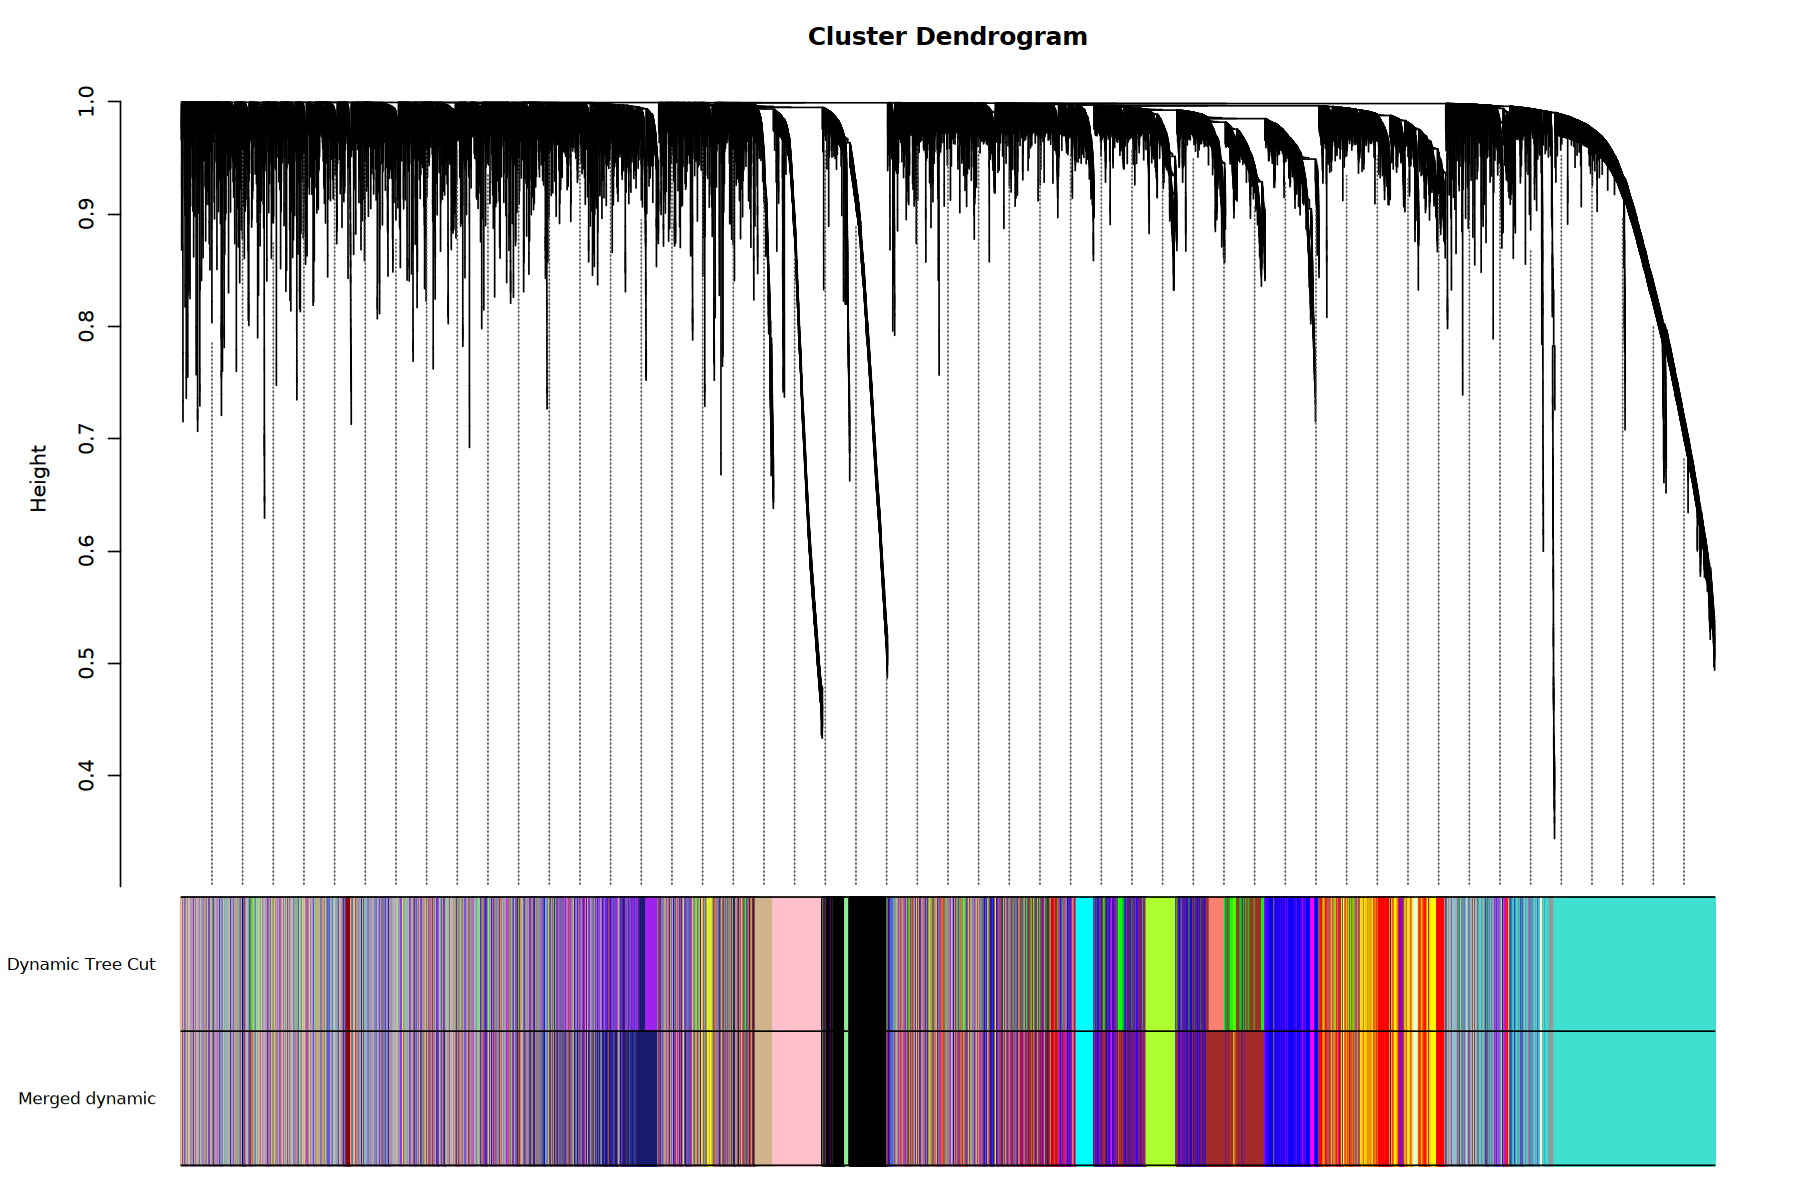

In [42]:
# Call an automatic merging function
merge <- mergeCloseModules(dataExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)

# The merged module colors
mergedColors <- merge$colors

# Eigengenes of the new merged modules:
mergedMEs <- merge$newMEs

# plot merged module colors
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors), 
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

### G. quantifying module-trait associations
identify modules that are significantly associated with treatment exposures or measured traits (like growth)

In [78]:
# read in phase info
dataMeta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv')

# keep only samples seen in dataExpr
dataMeta <- dataMeta[dataMeta$Sample %in% rownames(dataExpr),]

# create combo trtmt column
dataMeta$combo_trtmt <- paste0(dataMeta$Phase1_treatment, '_', dataMeta$Phase2_treatment)

# check it out
dim(dataMeta)
head(dataMeta)


[1] 93 10

,Sample,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,combo_trtmt
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
1,B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both_both
3,B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both_warm
4,B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5,both_both
5,B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4,both_control
7,B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4,both_both
8,B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3,both_control


values have to be numerical, so going to create a code for my treatments:

#### phase 1 and 2 treatments
1. control
2. warm
3. hypoxic
4. both

#### temperature
1. ambient
2. warm

#### dissolved oxygen
1. normoxic
2. hypoxic

In [83]:
# set factors
dataMeta$Phase1_treatment <- factor(dataMeta$Phase1_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase1_temp <- factor(dataMeta$Phase1_temp, c('ambient', 'warm'))
dataMeta$Phase1_DO <- factor(dataMeta$Phase1_DO, c('normoxic', 'hypoxic'))

dataMeta$Phase2_treatment <- factor(dataMeta$Phase2_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase2_temp <- factor(dataMeta$Phase2_temp, c('ambient', 'warm'))
dataMeta$Phase2_DO <- factor(dataMeta$Phase2_DO, c('normoxic', 'hypoxic'))

# convert categorical to numerical code for treatment info
### PHASE 1
dataMeta$P1_trtmt_code <- as.numeric(factor(dataMeta$Phase1_treatment))
dataMeta$P1_temp_code <- as.numeric(factor(dataMeta$Phase1_temp))
dataMeta$P1_DO_code <- as.numeric(factor(dataMeta$Phase1_DO))
### PHASE 2
dataMeta$P2_trtmt_code <- as.numeric(factor(dataMeta$Phase2_treatment))
dataMeta$P2_temp_code <- as.numeric(factor(dataMeta$Phase2_temp))
dataMeta$P2_DO_code <- as.numeric(factor(dataMeta$Phase2_DO))

# select only columns needed
metaData <- dataMeta[,-c(2:10)]

# set sample names as rownames
rownames(metaData) <- metaData$Sample
metaData <- metaData %>% select(-Sample)

head(metaData)


,P1_trtmt_code,P1_temp_code,P1_DO_code,P2_trtmt_code,P2_temp_code,P2_DO_code
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B1_B1_O01,4,2,2,4,2,2
B1_W5_O50,4,2,2,2,2,1
B2_B5_O51,4,2,2,4,2,2
B2_C4_O40,4,2,2,1,1,1
B3_B4_O41,4,2,2,4,2,2
B3_C3_O30,4,2,2,1,1,1


In [72]:
# define # of genes and samples
nSamples <- nrow(dataExpr)
nGenes <- ncol(dataExpr)

eigengene ~ summary profile of the module

now can correlate eigengenes with external traits and look for most significant associations

In [86]:
# Recalculate MEs (module eigengenes) with color labels

MEs0 <- moduleEigengenes(dataExpr, mergedColors)$eigengenes # create module eigengenes

MEs <- orderMEs(MEs0) # order so more similar modules are closer together

moduleTraitCor <- cor(MEs, metaData, use = "p") # correlate with traits - using Pearson correlations

moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples) # compute p-values - uses student's t-distribution

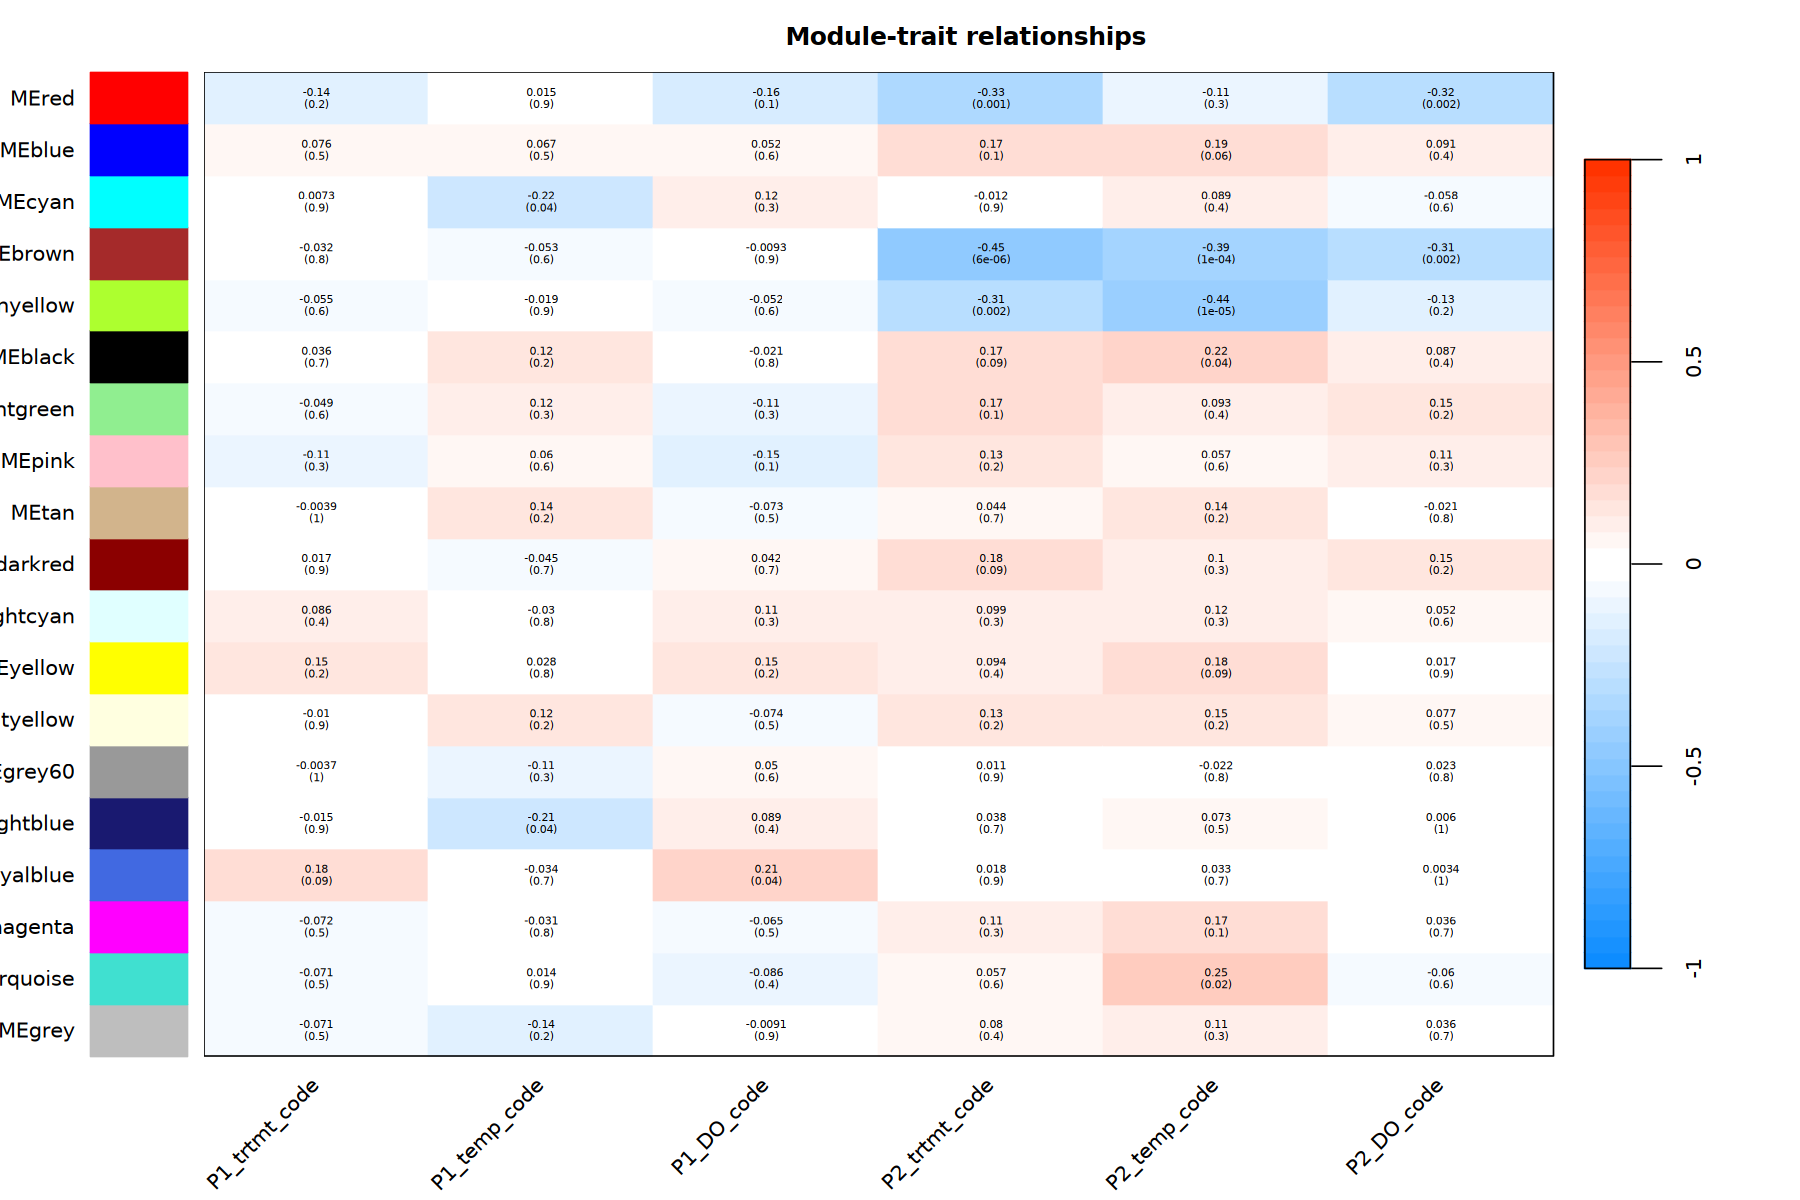

In [87]:
# Will display correlations and their p-values
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3))

# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor, 
               xLabels = names(metaData), 
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

each row corresponds to a module eigengene, column to a treatment

each cell contains the corresponding correlation and p-value and the table is colored by correlation (in my case, I've assigned numerical codes to categorical treatments, with the control/normoxic/ambient treatment always being 1)

red cells indicate positive correlation, blue cells a negative correlation - looking for dark cells with significant pvalues to identify module of interest

### H. Gene significance and module membership
quantify associations of individual genes with trait of interest by defining gene significance (GS) as the abs. value of the correlation between the gene and the trait 

basically select a module of interest and validate with GS and MM

## not from this tutorial

In [28]:
net <- blockwiseModules(
  dataExpr,
  power = softPower,
  networkType = "signed",
  TOMType = "signed",
  minModuleSize = 30,
  mergeCutHeight = 0.25,
  numericLabels = TRUE,
  pamRespectsDendro = FALSE,
  verbose = 3
)


 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3    4    5    6 
4993 4944 4664 4544 3822 3580 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 23 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 415 genes from module 1 because their KME is too low.
     ..removing 396 genes from module 2 because their KME is too low.
     ..removing 415 genes from module 3 because their KME is too low.
     ..removing 306 genes from module 4 because their KME is too low.
     ..removing 1 genes fro

In [23]:
# extract module colors
moduleColors <- labels2colors(net$colors)
table(moduleColors)


moduleColors
         black           blue          brown           cyan      darkgreen 
           829           1436           1295            403            160 
      darkgrey    darkmagenta darkolivegreen     darkorange        darkred 
           109             31             36             98            191 
 darkturquoise          green    greenyellow           grey         grey60 
           158           1023            707          10691            293 
     lightcyan     lightgreen    lightyellow        magenta   midnightblue 
           297            230            220            734            339 
        orange  paleturquoise           pink         purple            red 
           104             43            817            719            861 
     royalblue    saddlebrown         salmon        skyblue      steelblue 
           220             49            574             79             46 
           tan      turquoise         violet          white         yellow 

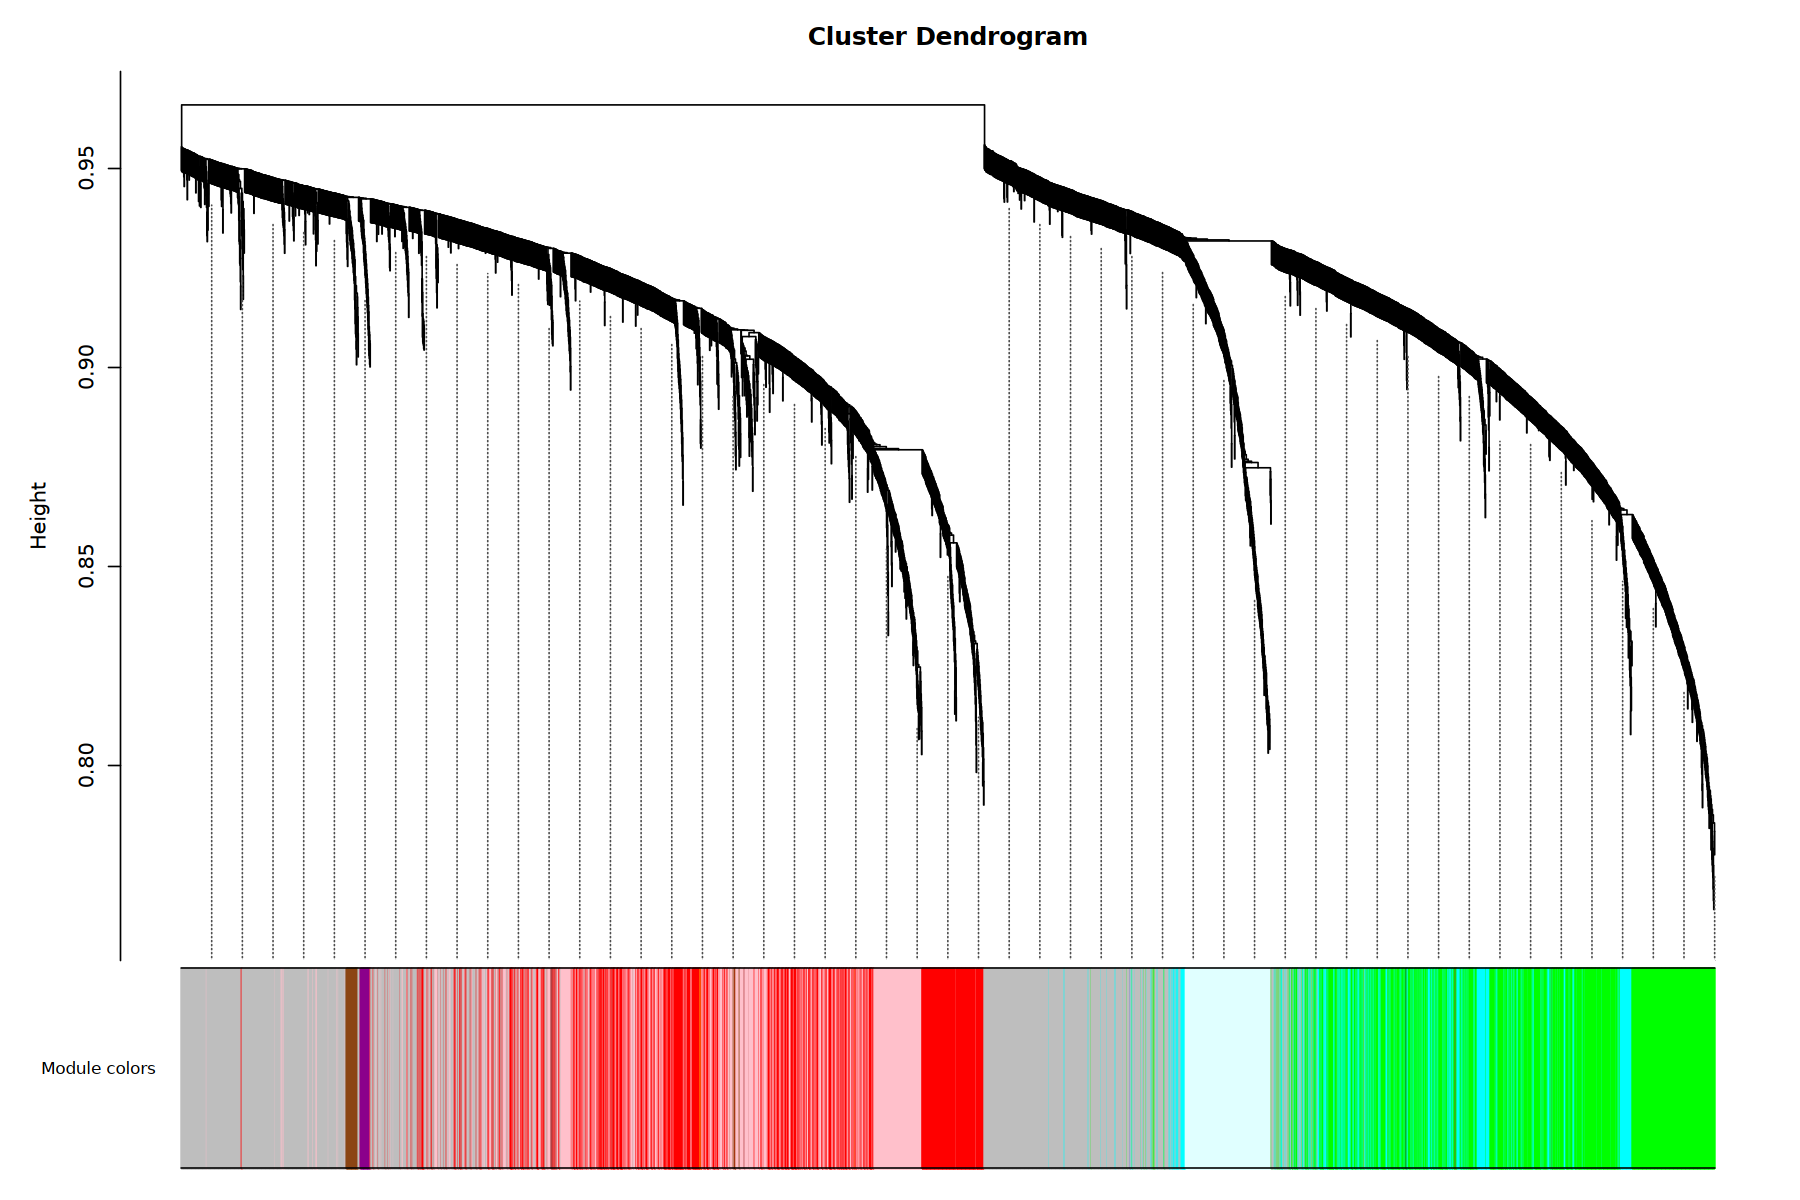

In [24]:
# visualize modules
plotDendroAndColors(
  net$dendrograms[[1]],
  moduleColors[net$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05
)


(how to read these:
- each leaf is a gene, genes are clustered by by topological overlap (TOM)
- height ≈ 1 − TOM similarity (lower merge height = more similar genes)
- each color block = one co-expression module
- grey = genes not assigned to module
- long, continuous blocks = stable modules
- thin blocks = small modules or borderline genes
)

based on plot:
- large blue module and large red/brown module - and leaves look like they match up to these